# Sentiment Analysis With Hotel Reviews

In [48]:
import pandas as pd

# read data
reviews_df = pd.read_csv("D:\Capstone Projects\Sentiment Analysis with hotel riview\Hotel_Reviews.csv")
# append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
# create the label
reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df.head()


,review,is_bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


Sample data

In [49]:
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)


The reviews data is randomly selected to accelerate the computational process.

Clean data

In [50]:
# remove 'No Negative' or 'No Positive' from text
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

If the user does not provide any negative feedback comment, it will be recorded as "No Negative" in our dataset. Similarly, positive comments are marked with the default value "No Positive". These phrases need to be excluded from our text data.

The subsequent stage involves cleaning the text data using a series of operations: 

In [53]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

To preprocess the textual data, we utilize our custom 'clean_text' function, which executes several transformations:

Lowercase the text.
Tokenize the text by splitting it into words and remove punctuation.
Eliminate irrelevant words containing numbers.
Exclude stopwords such as 'the', 'a', 'this', etc.
Perform Part-Of-Speech (POS) tagging to categorize each word as a noun, verb, etc., leveraging the WordNet lexical database.
Lemmatize the text to convert each word into its base form (e.g., 'rooms' to 'room', 'slept' to 'sleep').

Feature engineering

In [57]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

We initiate by incorporating sentiment analysis features as they provide insights into customers' sentiments regarding their hotel stay. Utilizing Vader, a component of the NLTK module specialized in sentiment analysis, we analyze the sentiment of the reviews. Vader employs a lexicon of words to identify positive and negative sentiments, considering the contextual nuances within sentences. Each text processed by Vader yields four values:

Neutrality score
Positivity score
Negativity score
Overall score, which consolidates the aforementioned scores
These four values will be integrated as features in our dataset.

In [58]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

Next, we add some simple metrics for every text:

number of characters in the text
number of words in the text

In [59]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

The subsequent step involves generating numerical vector representations for each review. Gensim, a module specialized in natural language processing, facilitates this process by employing Word2Vec to create numerical representations for words based on their contextual usage within the corpus. This is achieved through shallow neural networks, enabling similar words to have comparable representation vectors.

Furthermore, each text can be transformed into numerical vectors using Doc2Vec, a technique where texts with similar content exhibit similar numerical representations. Consequently, these vectors serve as valuable training features.

To begin, we train a Doc2Vec model by feeding our text data into it. Subsequently, we can utilize this model to derive representation vectors for our reviews, capturing their semantic essence in numerical form.

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns=tfidf.get_feature_names_out())
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)


Finally, we incorporate TF-IDF (Term Frequency-Inverse Document Frequency) values for each word in every document.

However, why not simply tally the occurrence of each word in each document? The issue with this approach is that it overlooks the relative significance of words in the texts. Words that appear frequently across all texts are unlikely to provide valuable insights for analysis. Conversely, rare words may carry more meaningful information.

The TF-IDF metric addresses this concern:

TF computes the standard count of times the word appears in the text.
IDF computes the relative importance of this word, which depends on how many texts the word is found in.
We introduce TF-IDF columns for every word that appears in at least 10 different texts to filter out some words and diminish the size of the final output.

In [62]:
reviews_df.head()

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,neg,...,yet,yoghurt,yogurt,young,yr,yummy,zero,ziggo,zone,zuid
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113,0.049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10,0.216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
reviews_df.shape

(51574, 3844)

# Exploratory data analysis
In order to have a better understanding of our data, let's explore it a little:

In [64]:
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.956761
1    0.043239
Name: is_bad_review, dtype: float64

Our dataset is highly imbalanced because less than 5% of our reviews are considered as negative ones. This information will be very useful for the modelling part.

Now let's print some wordclouds to have a glimpse at what kind of words apear in our reviews

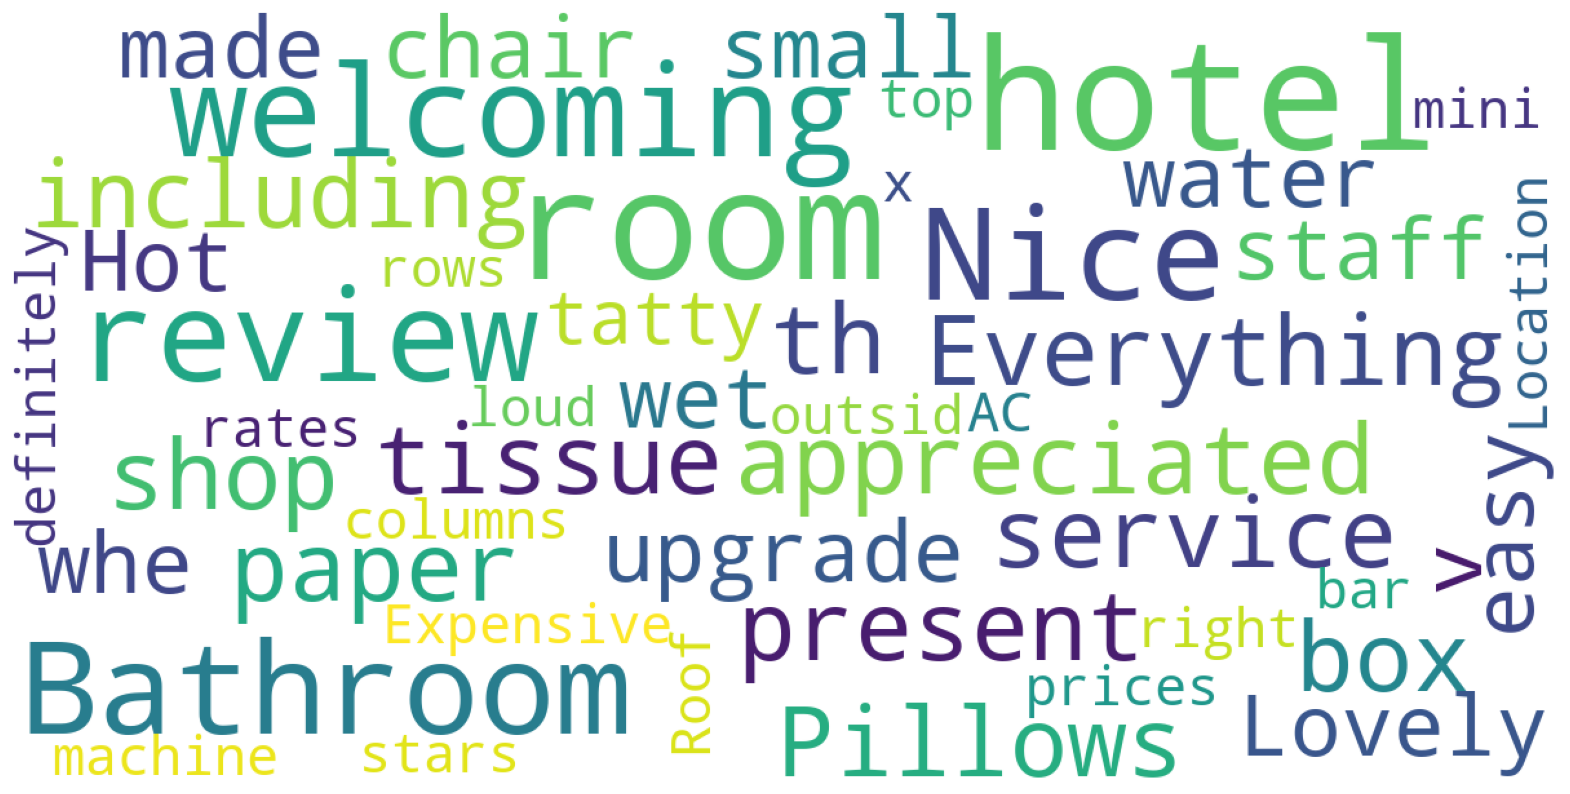

In [65]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])


Most of the words are indeed related to the hotels: room, staff, breakfast, etc. Some words are more related to the customer experience with the hotel stay: perfect, loved, expensive, dislike, etc.

In [67]:
# Check for duplicate column names
duplicate_columns = reviews_df.columns[reviews_df.columns.duplicated()]
print("Duplicate column names:", duplicate_columns)

Duplicate column names: Index(['neg', 'neu', 'pos', 'compound', 'review'], dtype='object')


In [69]:
# Drop duplicate columns
reviews_df = reviews_df.loc[:,~reviews_df.columns.duplicated()]

In [70]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
43101,A perfect location comfortable great value,0.931
211742,Clean comfortable lovely staff,0.907
175551,Friendly welcome Comfortable room,0.905
365085,Good location great value,0.904
109564,Clean friendly and comfortable,0.902
145743,Good value amazing location,0.901
407590,breakfast excellent Clean comfort,0.899
407546,Great place I enjoyed,0.881
218571,Beautiful Quirky Comfortable,0.878
436901,Lovely comfortable rooms,0.877



The reviews with the highest positivity scores generally reflect positive feedback about the hotel experience.

In [71]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
193086,No dislikes LOCATION,0.831
356368,Nothing Great helpful wonderful staff,0.812
318516,A disaster Nothing,0.804
458794,Nothing Excellent friendly helpful staff,0.799
29666,A bit noisy No,0.796
426057,Dirty hotel Smells bad,0.762
263187,Very bad service No,0.758
443796,Nothing perfect,0.750
181508,Window blind was broken,0.744
175316,Nothing Super friendly staff,0.743



While the majority of reviews are negative, it's worth noting that among the most negative reviews, some errors can be observed. This is because Vader occasionally interprets words like 'no' or 'nothing' as negative, even though they may be used to indicate that there were no issues with the hotel.

C:\Users\ASHIF\AppData\Local\Temp\ipykernel_3480\1439915955.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['compound'], hist = False, label = label)
C:\Users\ASHIF\AppData\Local\Temp\ipykernel_3480\1439915955.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sub

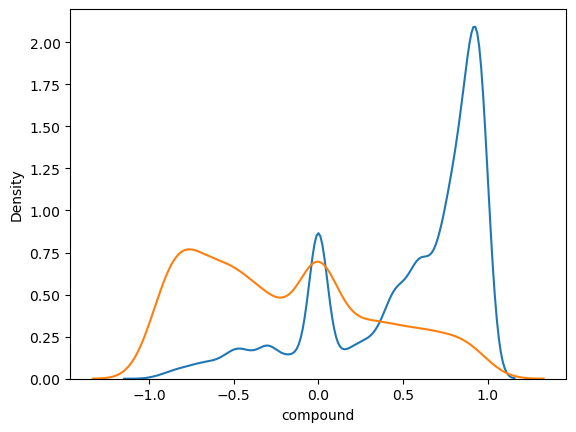

In [77]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)


The graph above illustrates the distribution of sentiment scores for both good and bad reviews. It's evident that good reviews predominantly receive very positive sentiment scores according to Vader. Conversely, bad reviews tend to exhibit lower compound sentiment scores.

This observation underscores the significance of the sentiment features we computed earlier, emphasizing their potential importance in our subsequent modeling phase.

# Modelling reviewer_score

In [78]:
# feature selection
label = "is_bad_review"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

We first choose which features we want to use to train our model. Then we split our data into two parts:

one to train our model
one to assess its performances
We will next use a Random Forest (RF) classifier for our predictions.

In [79]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.037882
6,doc2vec_vector_0,0.025571
0,neg,0.024226
2,pos,0.023281
8,doc2vec_vector_2,0.018175
10,doc2vec_vector_4,0.018002
9,doc2vec_vector_3,0.016919
7,doc2vec_vector_1,0.016392
4,nb_chars,0.016157
1,neu,0.015840



Indeed, the paramount features emerge from the preceding sentiment analysis, followed closely by the vector representations of the texts, which carry significant weight in our training process. Additionally, certain words demonstrate noteworthy importance, further contributing to the predictive power of our model.

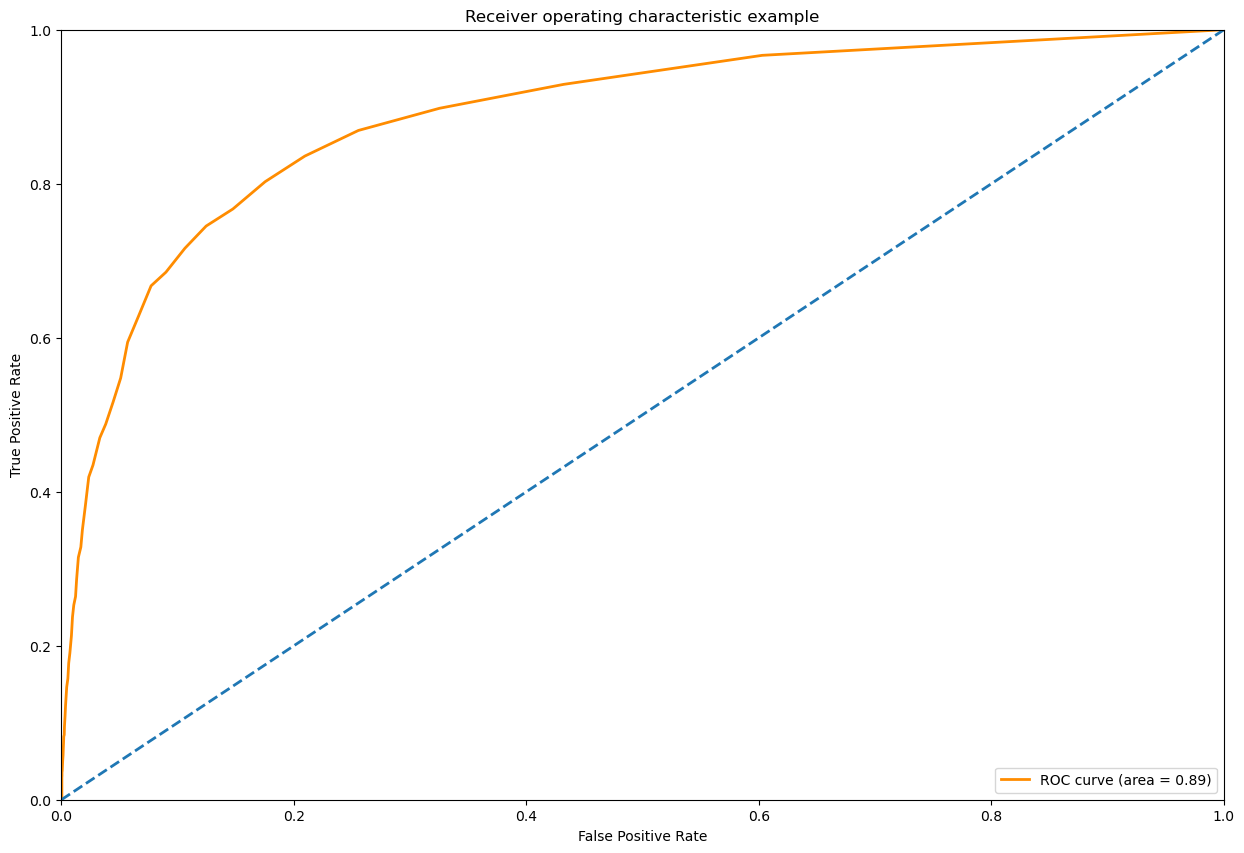

In [80]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


While the AUC ROC (Area Under the Curve ROC) metric may indicate high performance, relying solely on the ROC curve to evaluate our model's quality may be misleading in this scenario. This is due to the imbalanced nature of our dataset, where the number of negative reviews (representing the "negatives" in the False Positive Rate calculation) vastly outweighs the number of positive reviews. Consequently, even with some False Positives, the False Positive Rate (FPR) tends to remain low. As a result, the model could generate numerous false positive predictions while maintaining a low FPR, thereby artificially inflating the AUC ROC metric.

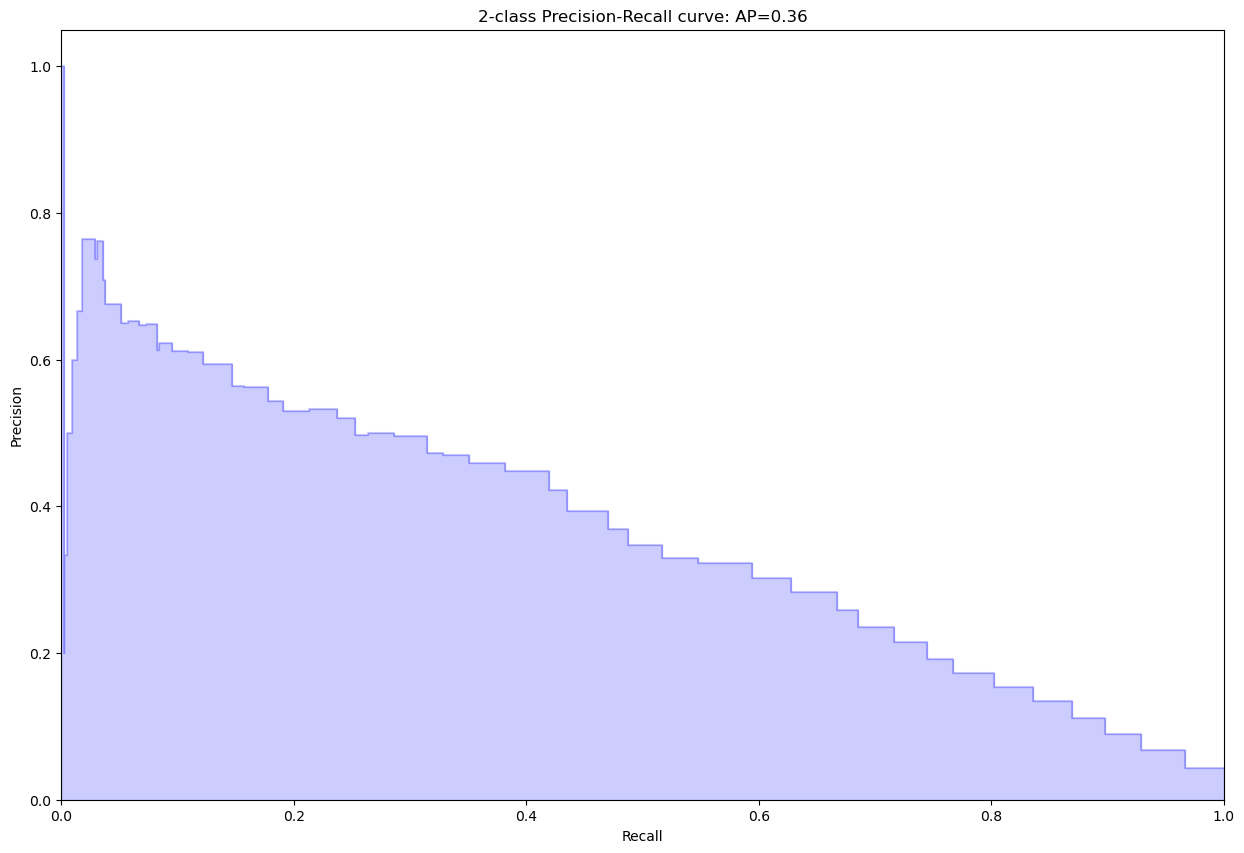

In [83]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure(1, figsize=(15, 10))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In situations with imbalanced data, the Area Under the Curve Precision-Recall (AUC PR) or Average Precision (AP) is a better metric than the AUC ROC. Unlike the ROC curve, which assesses the trade-off between true positive rate and false positive rate, the precision-recall curve demonstrates the trade-off between precision and recall.

The precision-recall curve illustrates that as recall increases, precision tends to decrease. This indicates the necessity of choosing a prediction threshold that aligns with our objectives. For instance, if our priority is to capture as many positive observations as possible (high recall), we might opt for a lower prediction threshold, even if it leads to lower precision. Conversely, if we prioritize precision over recall, we would choose a higher prediction threshold.

Comparing our model's performance to a simple decision baseline provides valuable insights. In this scenario, we consider a random classifier that predicts positive and negative labels with equal probability, resulting in a precision of 4.3% (the proportion of positive observations). This precision remains constant regardless of the recall value, yielding an AP of 0.043.

In contrast, our model achieves an AP of approximately 0.35, indicating that it outperforms the random baseline by more than eight times. This suggests that our model possesses significant predictive power and provides valuable insights compared to random guessing.

# Conclusion


Utilizing raw text data alone for making predictions is entirely feasible, provided that relevant features can be extracted effectively. Raw text serves as a valuable source of information that can complement existing data sources in data science projects. By extracting additional learning features from raw text, we enhance the predictive capabilities of our models, thereby augmenting their effectiveness in various applications.